### Prepare Workspace

In [10]:
# Import system libraries
import os
import sys

# Import data cleaning libraries
import pandas as pd
import numpy as np
import calendar
from datetime import datetime

# Import machine learning libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
import shap

# Import data visualisation libraries
import matplotlib.pyplot as plt 

# Import warning libraries
import warnings
warnings.filterwarnings("ignore")

# Set working directory
os.chdir('T:\crop-yield-estimate') ##Set this to your own path
sys.path.insert(0, 'T:\crop-yield-estimate\pipeline') ##Set this to your own path

# Import preprocessing libraries
from preprocessing import cleaning
from preprocessing import feature_engineering
from preprocessing import scaling
from preprocessing import feature_selection
from preprocessing import dim_reduction

# Preprocess data
train_path = "data/Train.csv"
test_path = "data/Test.csv"
df = cleaning.clean_data(train_path, test_path)
df = feature_engineering.get_features(df)
df = scaling.scale_features(df)
df = feature_selection.select_features(df)
df = dim_reduction.reduce_dim(df)

# Split data into training and test sets
df_train = df[df['Yield'].isna() == False]
df_test = df[df['Yield'].isna() == True]

In [11]:

print(shap.__version__)


0.43.0


### Build Yield Generic Yield Per Acre Model

In [12]:
outcome_cols = ["Yield","Yield_per_Acre","New_Yield","New_Yield_per_Acre"]




In [13]:

# Split data
outcome_cols = ["Yield","Yield_per_Acre","New_Yield","New_Yield_per_Acre"]

# Drop columns excluding the top features
X, y = df_train.drop(outcome_cols, axis=1), df_train["New_Yield_per_Acre"]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [10, 50, 100]
}

# Instantiate an XGBoost regressor model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best parameters and best score from grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Train the XGBoost model with the best parameters
xg_reg_best = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, **best_params)
xg_reg_best.fit(X_train, y_train)

# Predict on the test set using the best model
y_pred_best = xg_reg_best.predict(X_test)


indices = list(y_test.index)


# Evaluate the best model using RMSE (Root Mean Squared Error)
rmse_best = mean_squared_error(df_train.loc[indices]["New_Yield"], y_pred_best * df_train.loc[indices]["Acre"], squared=False)
print("Best Model - Root Mean Squared Error:", rmse_best)


Best Model - Root Mean Squared Error: 111.66185816652634


In [14]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 774 entries, 2176 to 691
Columns: 193 entries, CultLand to PC21
dtypes: bool(93), float64(100)
memory usage: 681.0 KB


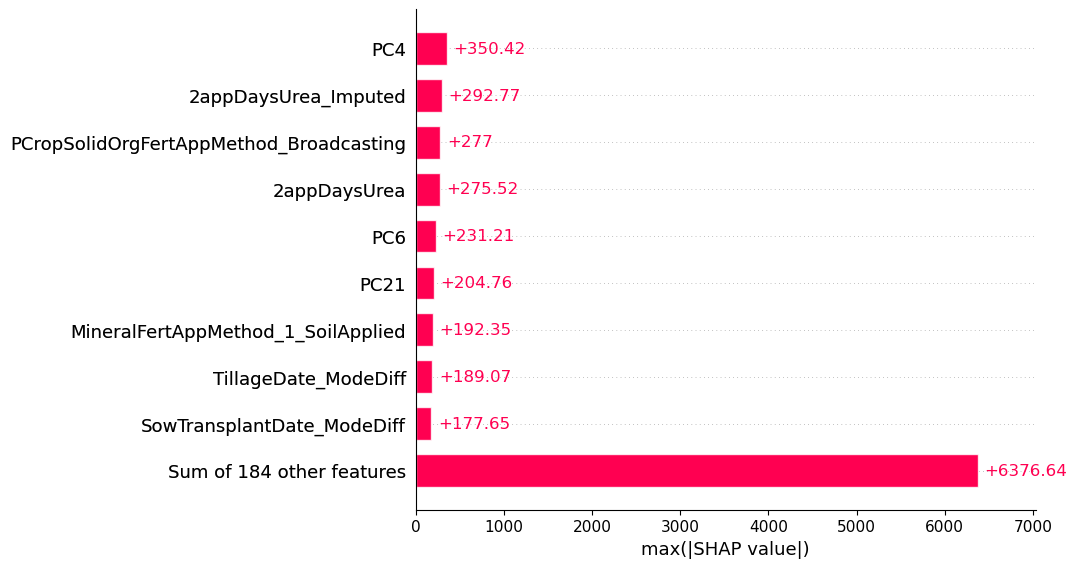

In [15]:
# Create a TreeExplainer object with the XGBoost model
explainer = shap.TreeExplainer(xg_reg_best)

# Calculate Shapley values for a specific sample (replace index with your desired sample index)
shap_values = explainer.shap_values(X_test)

# Summary plot of Shapleys values
shap.plots.bar(explainer(X_test).abs.max(0))

In [16]:
top_columns = []

# Calculate the maximum absolute value of each column in the shap_values matrix
column_max_abs = np.max(np.abs(shap_values), axis=0)

# Attach maximum absolute values to column names
column_max_with_names_abs = {column: max_val for column, max_val in zip(X_test.columns, column_max_abs)}

# Sort the column maximum absolute values in descending order
sorted_column_max_abs = sorted(column_max_with_names_abs.items(), key=lambda x: x[1], reverse=True)

# Save all column names into a sorted array
sorted_columns = [column for column, _ in sorted_column_max_abs]

# Display top N column names with their maximum absolute values in descending order
for column, max_val in sorted_column_max_abs:
    top_columns.append(column)

In [17]:
top_columns

['PC4',
 '2appDaysUrea_Imputed',
 'PCropSolidOrgFertAppMethod_Broadcasting',
 '2appDaysUrea',
 'PC6',
 'PC21',
 'MineralFertAppMethod_1_SoilApplied',
 'TillageDate_ModeDiff',
 'SowTransplantDate_ModeDiff',
 'CultLand',
 'Harv_hand_rent_per_Acre',
 'Ganaura',
 'PC20',
 'Harv_hand_rent',
 'PCropSolidOrgFertAppMethod_SoilApplied',
 'ThreshingMonth_January',
 'CropTillageDepth',
 'ThreshingDate_ModeDiff',
 'FirstTopDressFert_DAP_True',
 'PC14',
 'PC10',
 'TransIrriCost_per_Acre_capped',
 'Acre',
 'Days_bw_Nurs_Harv',
 'Days_bw_Till_SowTransp',
 'Days_bw_Nurs_SowTransp_ModeDiff',
 'HarvestDate_ModeDiff',
 'Ganaura_per_Acre',
 'PC15',
 'TransIrriCost_per_Acre',
 'CropOrgFYM_per_Acre',
 'Acre_Scaled',
 'TransplantingIrrigationHours_per_Acre',
 'PC18',
 'CropCultLand',
 'PC8',
 '1tdUrea',
 'Longitude',
 'Latitude',
 'PC13',
 'Ganaura_capped',
 'NursingDate_ModeDiff',
 'BasalUrea_per_Acre',
 '2appDaysUrea_MeanDiff',
 'TpIrrigationPowerSource_Imputed_Diesel',
 'Num_TransDetFactor',
 'Num_OrgFert

In [18]:
import numpy as np

# Initialize variables to store the best N and lowest RMSE
best_N = 1
lowest_rmse = float('inf')

# Iterate over the range of N values from 1 to 100
for N in range(1, len(top_columns) + 1):
    # Split data
    outcome_cols = ["Yield","Yield_per_Acre","New_Yield","New_Yield_per_Acre"]

    # Drop columns excluding the top features
    X, y = df_train.drop(outcome_cols, axis=1), df_train["New_Yield_per_Acre"]

    # Drop columns that are not the top columns
    X = X[top_columns[:N]]  # Get the first N columns from top_columns

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the parameter grid for grid search
    param_grid = {
        'learning_rate': [0.1, 0.01, 0.001],
        'max_depth': [3, 5, 7],
        'n_estimators': [10, 50, 100]
    }

    # Instantiate an XGBoost regressor model
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score from grid search
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Train the XGBoost model with the best parameters
    xg_reg_best = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, **best_params)
    xg_reg_best.fit(X_train, y_train)

    # Predict on the test set using the best model
    y_pred_best = xg_reg_best.predict(X_test)

    # Evaluate the best model using RMSE (Root Mean Squared Error)
    rmse_best = mean_squared_error(df_train.loc[indices]["New_Yield"], y_pred_best * df_train.loc[indices]["Acre"], squared=False)

    # Check if the current N gives a lower RMSE than the previous lowest RMSE
    if rmse_best < lowest_rmse:
        lowest_rmse = rmse_best
        best_N = N

    # Print the best N and lowest RMSE
    print("Best N:", best_N)
    print("Lowest RMSE:", lowest_rmse)

    # Save the print statements to a text file
    with open('output.txt', 'w') as file:
        file.write("Best N: " + str(best_N) + "\n")
        file.write("Lowest RMSE: " + str(lowest_rmse) + "\n")

    # Check if the current N gives a lower RMSE than the previous lowest RMSE
    if rmse_best < lowest_rmse:
        lowest_rmse = rmse_best
        best_N = N

# Print the best N and lowest RMSE
print("Best N:", best_N)
print("Lowest RMSE:", lowest_rmse)


Best N: 1
Lowest RMSE: 157.62239515847074
Best N: 2
Lowest RMSE: 146.26648423971992
Best N: 3
Lowest RMSE: 146.1833810970901
Best N: 4
Lowest RMSE: 146.08707347777715
Best N: 5
Lowest RMSE: 145.616137962825
Best N: 5
Lowest RMSE: 145.616137962825
Best N: 7
Lowest RMSE: 140.0505747813332
Best N: 8
Lowest RMSE: 136.32298609429628
Best N: 9
Lowest RMSE: 133.00272575546305
Best N: 10
Lowest RMSE: 131.54990824986086
Best N: 10
Lowest RMSE: 131.54990824986086
Best N: 12
Lowest RMSE: 128.8262479039275
Best N: 13
Lowest RMSE: 122.31823507274686
Best N: 14
Lowest RMSE: 117.8778105423326
Best N: 14
Lowest RMSE: 117.8778105423326
Best N: 14
Lowest RMSE: 117.8778105423326
Best N: 14
Lowest RMSE: 117.8778105423326
Best N: 18
Lowest RMSE: 117.10667501332054
Best N: 18
Lowest RMSE: 117.10667501332054
Best N: 20
Lowest RMSE: 117.07746059841375
Best N: 21
Lowest RMSE: 116.16083137516662
Best N: 21
Lowest RMSE: 116.16083137516662
Best N: 21
Lowest RMSE: 116.16083137516662
Best N: 21
Lowest RMSE: 116.160

Exception ignored in: <function Booster.__del__ at 0x0000021807905D30>
Traceback (most recent call last):
  File "C:\Users\shawa\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py", line 1752, in __del__
    _check_call(_LIB.XGBoosterFree(self.handle))
KeyboardInterrupt: 


In [ ]:
# Create a TreeExplainer object with the XGBoost model
explainer = shap.TreeExplainer(xg_reg_best)

# Calculate Shapley values for a specific sample (replace index with your desired sample index)
sample_index = 21
shap_values = explainer.shap_values(X_test)

# Summary plot of Shapleys values
shap.plots.bar(explainer(X_test).abs.max(0))

### Make Predictions

In [ ]:
# # Retrain model on entire training data
# xg_reg.fit(X, y)
# print("---Training complete---")

In [ ]:
# # Make predictions
# test_predictors = df_test.drop(outcome_cols, axis=1)
# test_pred = xg_reg.predict(test_predictors) * df_test["Acre"]

# # Add predictions to sample submission file
# df_test_pred = pd.read_csv("data/SampleSubmission.csv")
# df_test_pred['Yield'] = test_pred
# df_test_pred['Yield'] = np.where(df_test_pred['ID'] == 'ID_PMSOXFT4FYDW',
#                                  df_test_pred['Yield'] * 10, df_test_pred['Yield'])

# # Export submission
# df_test_pred.to_csv('submission/Submission.csv', index=False)

# print("---Predictions made---")